<a href="https://www.kaggle.com/code/bensonduong/font-type-image-classification?scriptVersionId=108274206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Typeface Categorization using Unsupervised Learning, Convolutional Neural Network, and OpenCV**
* This data science computer vision project will be about using Unsupervised Clustering Methods to categorize fonts into groups based on visual attributes (serif, sans-serif, cursive, etc.).
* These font categories will be initially grouped through **Unsupervised Learning**, like **Principal Component Analysis Eigen-decomposition**, and specifically **Spectral Embedding**, finally designated with **K-means Clustering**. 
* This dataset in turn uses actual typefaces from the UC Irvine Font Dataset https://archive.ics.uci.edu/ml/datasets/Character+Font+Images
* These labellings will be used for training a **convolutional neural network** with variable-input-size, meaning it can classify the general font types of completely new and unseen typefaces. This CNN will allow variable input size for the versatile dimensions of the incoming segmented characters.
* Eventually, this neural network will take in photoscanned images of text documents, and classify the most predominant font type (where these groups are those learned at the start). This will use OpenCV's OCR, and character image segmentation to extract the fonts from said images of text.

## **Part 0:  Data Preparation**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import seaborn as sns

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
import sklearn.decomposition
from sklearn.preprocessing import normalize
import sklearn.neighbors
import sklearn.manifold
from sklearn.cluster import KMeans

from tqdm import tqdm

In [3]:
import cv2
import urllib.request
from tensorflow import keras
import tensorflow as tf
from keras.optimizers import adam_v2

In [4]:
file_names = []
file_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = (os.path.join(dirname, filename))
        file_paths.append(filepath)
        file_names.append(filename)

In [5]:
def prepare_font_df(font_df_orig):
    # For each font's csv table, the column "m_label" denotes an identifier for a certain character
    # The variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
    MIN_M_LABEL = 33
    MAX_M_LABEL = 126
    m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
    m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
    m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
    m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

    CHOSEN_M_LABELS = []
    CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
    #CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
    #CHOSEN_M_LABELS += m_labels_alphanum_num

    curr_font_df = font_df_orig
    
    ERROR_FONTS = ['BITSTREAMVERA','CREDITCARD', 'E13B', 'HANDPRINT', 'MONEY', 'NUMERICS', 'VIN']
    curr_font_df = curr_font_df[curr_font_df["font"].isin(ERROR_FONTS)==False]
    # Remove Errored Fonts
    curr_font_df = curr_font_df[curr_font_df["fontVariant"]!="scanned"]
    # Removed Scanned Pictures
    curr_font_df = curr_font_df[curr_font_df["m_label"].isin(CHOSEN_M_LABELS)] 
    # get the chosen labels 
    curr_font_df = curr_font_df.sort_values(["font","m_label"]) 
    # make sure that the characters are in order, which is necessary for a horizontal concatenation and consistent embedding later on.
    curr_font_df = curr_font_df[curr_font_df["strength"] <= 0.5] 
    # remove bolded
    curr_font_df = curr_font_df[curr_font_df["italic"] <= 0.5] 
    # remove italicized
    curr_font_df = curr_font_df.drop_duplicates(subset=["font","m_label","strength","italic"]) 
    curr_font_df = curr_font_df.sort_values(["font","m_label"])
    return curr_font_df

In [6]:
uci_font_family_csv_file_names = file_names
range_len_uci_font_family_csv_file_names = range(len(uci_font_family_csv_file_names))
range_len_uci_font_family_csv_file_names = tqdm(range_len_uci_font_family_csv_file_names)

font_df_concat_list = []

for i in range_len_uci_font_family_csv_file_names:
    #if (((i+1)%25)==0): print(i+1, len(uci_font_family_csv_file_names));
    uci_font_family_csv_file_name = uci_font_family_csv_file_names[i]
    uci_font_family = uci_font_family_csv_file_name.split(".csv")[0]
    # uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    uci_font_family_csv_file_path = file_paths[i]
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    temp_uci_font_family_df_orig = prepare_font_df(temp_uci_font_family_df_orig)
    font_df_concat_list.append(temp_uci_font_family_df_orig)

100%|██████████| 153/153 [00:50<00:00,  3.05it/s]


In [7]:
font_df_orig = pd.concat(font_df_concat_list, axis=0)

In [8]:
print("font_df_orig.shape = ",font_df_orig.shape)

font_df_orig.head(5)
#font_df_orig.shape =  (832670, 412)

font_df_orig.shape =  (3796, 412)


,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
361,SKETCHFLOW,SKETCHFLOW PRINT,65,0.4,0,0.0,26,21,53,43,...,1,1,1,1,1,30,229,255,126,1
360,SKETCHFLOW,SKETCHFLOW PRINT,66,0.4,0,0.0,31,26,46,46,...,1,1,1,1,1,1,1,1,1,1
359,SKETCHFLOW,SKETCHFLOW PRINT,67,0.4,0,0.0,31,22,45,44,...,1,1,1,1,1,1,1,1,1,1
358,SKETCHFLOW,SKETCHFLOW PRINT,68,0.4,0,0.0,29,24,48,43,...,1,1,1,1,1,1,1,1,1,1
357,SKETCHFLOW,SKETCHFLOW PRINT,69,0.4,0,0.0,30,27,45,42,...,14,1,1,1,1,1,1,1,1,1


* You can change which characters you want to use in the CHOSEN_M_LABELS variable . 
* But for this unsupervised classification, I'm going to just use the 26 capital letters to represent each font
* My main reason is that most capital letters are arguably square-shaped and thus proportionally consistent in anatomy for most fonts. In this dataset, thin or wide characters (like lowercase, numbers, and punctuation) get forcibly stretched or narrowed to fit a 20x20 space, making it inconsistent.
* We also removed error prone fonts
* Removed badly photoscanned pictures
* De-italicize
* Un-emboldened
* Removed Duplicates

In [9]:
# each row of the csv table has a 20x20 image for the character it represents, 
# which can be made using a group of 400 columns. These column names are collected here for future use
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)

In [10]:
assert np.all(font_df_orig["font"].value_counts()==26)
unraveled_alphabets = font_df_orig[pixel_column_names].values.reshape(3796//26, 20*20*26)

In [11]:
passed_font_families = list(font_df_orig["font"].drop_duplicates())

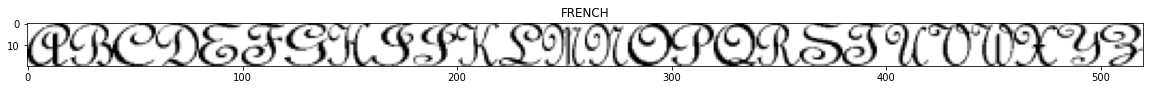

In [12]:
# demonstration of using the font_visualization list
GIVEN_FONT = "FRENCH" # input any font from the dataset, make sure it's in capital letters

def get_alphabet_array_of_font(GIVEN_FONT):
    given_font_index = passed_font_families.index(GIVEN_FONT)
    alphabet_image = np.hstack(unraveled_alphabets[given_font_index].reshape((26,20,20)))
    return alphabet_image
def plot_font(GIVEN_FONT):
    fig_temp, ax_temp = plt.subplots(figsize=(20,20))
    alphabet_image = get_alphabet_array_of_font(GIVEN_FONT)
    plt.imshow(255-alphabet_image, cmap="gray")
    plt.title(GIVEN_FONT)
plot_font(GIVEN_FONT)

## **Part 1:  Unsupervised Grouping of Fonts**

* The main goal of Part 1 of this project is finding a way to group up fonts by visual traits in an automatic way, without the need of a human manually observing and labeling each font. For Example, groups might be: Sans-serif, serif, cursive, messy everyday handwriting, etc.

Different methods to group the fonts will be used;
1. Principal Component Analysis ("eigen-fonts")
2. Spectral Embeddings built from the similiarity matrix (normalized gram matrix)

In [13]:
eig_fonts_x = np.array(unraveled_alphabets)
# eig_fonts_x.shape # is (147, 10400)

### Method 1. Principal Component Analysis ("Eigen-Fonts")
* In this section, Principal Component Analysis will be used to see if it can adequately find "groups" of fonts by visual traits.
* In addition, the idea of eigenfaces will be employed on fonts (see https://en.wikipedia.org/wiki/Eigenface)

In [14]:
eig_fonts_x = np.array(unraveled_alphabets).astype(np.float32)
eig_fonts_x /= 255

C = np.cov(eig_fonts_x.T)
eigvals, eigvecs = np.linalg.eigh(C)

**Plotting "Eigen-Fonts"**

* The font plotted below doesn't actually exist, it is actually the 3rd largest eigenvector, completely derived from our own data. As you can see, it looks like a serifed font. 

array([0.        , 0.        , 0.00018469, ..., 0.02382875, 0.02385949,
       0.01359589])

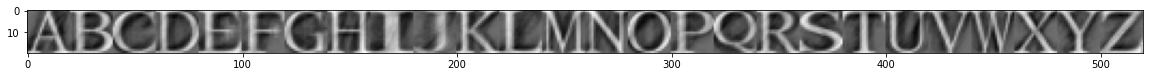

In [15]:
def plot_eigenfont(eigvecs, i):
    u = eigvecs[:, -i]
    fig_temp, ax_temp = plt.subplots(figsize=(20,20))
    temp_font_unraveled = u
    temp_font = np.hstack(temp_font_unraveled.reshape(26,20,20))#.shape
    plt.imshow(temp_font, cmap="gray")
    return u
plot_eigenfont(eigvecs, 3)

**Plotting each eigenvector tries to show a specific "generalization" of fonts.**
* So the takeaway is grouping the fonts by which eigenvector/"eigenfont" best generalizes them the most with.

In [16]:
#print(eigvecs.shape)
#print(unraveled_alphabets.shape)

# each real row is 1 by 10400
# each eigenvector column (eigenfont) is 10400 by 1
# if we can normalize both and get the dotproducts (so that it's -1 to 1)
# then arg max them or employ NNMF (which requires absolute value)
eigvecs_normalized = eigvecs/np.linalg.norm(eigvecs, axis=0, keepdims=True)
unraveled_alphabets_normalized = unraveled_alphabets/np.linalg.norm(unraveled_alphabets, axis=1,keepdims=True)
print(np.linalg.norm(unraveled_alphabets_normalized,axis=1).mean())
print(np.linalg.norm(eigvecs_normalized,axis=0).mean())
eigenfont_pca = unraveled_alphabets_normalized @ eigvecs_normalized 
print(eigenfont_pca.min(), eigenfont_pca.max())

1.0
1.0
-0.9477557626601419 0.64445429670833


In [17]:
temp_eigenfont_df = pd.DataFrame()
temp_eigenfont_df["font"]= passed_font_families
temp_eigenfont_df["eigenfont"]= 10400-np.argmax((eigenfont_pca),axis=1)
eigenfont_groupby = temp_eigenfont_df.groupby(["eigenfont"],as_index=False).agg({"font": list})
eigenfont_groupby

,eigenfont,font
0,2,"[SKETCHFLOW, AGENCY, REFERENCE, LUCIDA, MONOTX..."
1,3,"[COOPER, PERPETUA, MODERN, HIMALAYA, CASTELLAR..."
2,4,"[MV_BOLI, BUXTON, MISTRAL, CHILLER]"
3,6,"[ROCKWELL, MONOTYPE, FRENCH, GOUDY, COMMERCIAL..."
4,7,"[RAGE, MAGNETO, HAETTENSCHWEILER, GUNPLAY, PRI..."
5,9,[EDWARDIAN]
6,11,[ENGLISH]
7,12,[HARLOW]
8,13,[PLAYBILL]
9,14,[GOTHICE]


* The fonts are now grouped together by their best matching "eigenfont" in the table above. 
    * There are several fonts that are supposedly visually distinct enough to be their own group.
    * Other fonts however, have found their own group. 

For example, let's see what the fonts in Eigenfont 4 looks like. When plotted below, it seems like Eigenfont 4's fonts are a messy handwriting group.

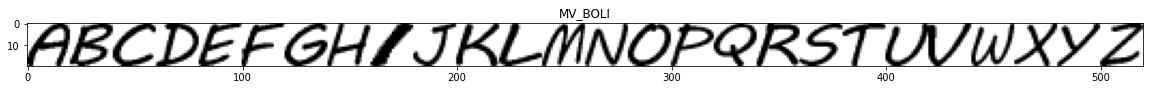

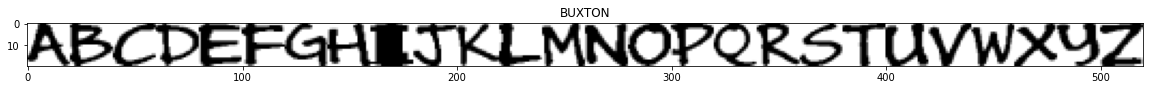

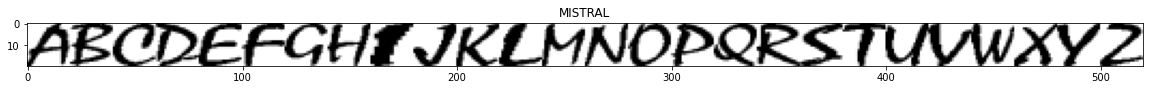

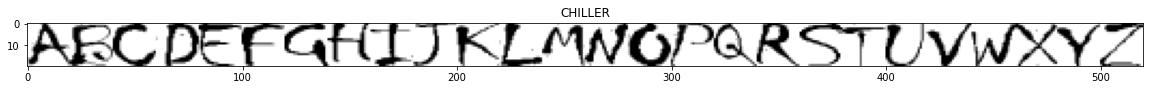

In [49]:
for font in eigenfont_groupby["font"].values[2]: plot_font(font)

Eigenfont 3 are the serif fonts, as shown earlier:

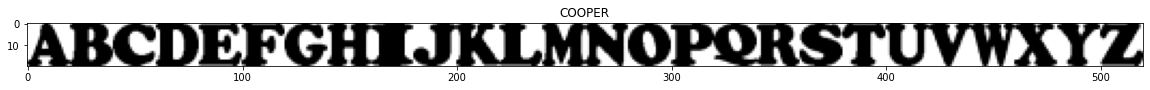

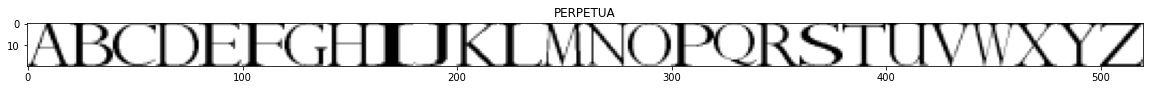

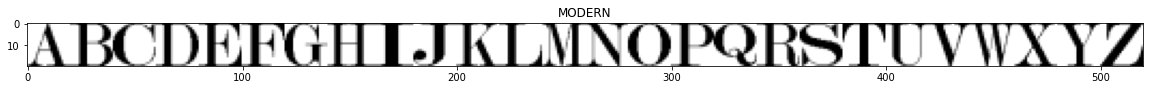

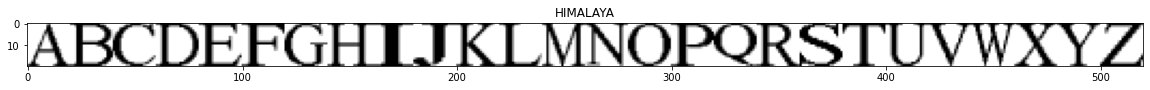

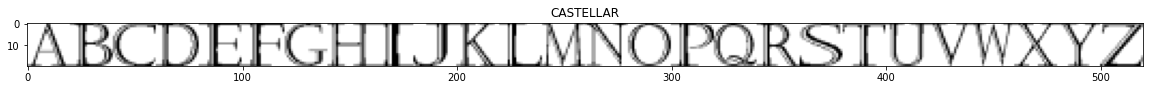

In [19]:
for font in eigenfont_groupby["font"].values[1][:5]: plot_font(font)

It seems like Eigenfont 2 have san-serif fonts:

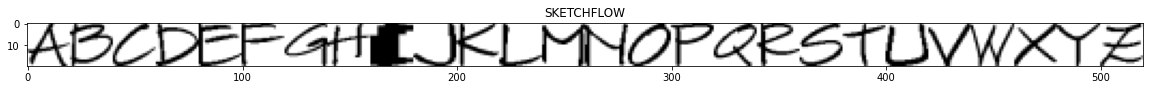

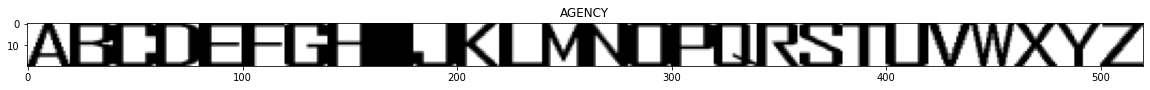

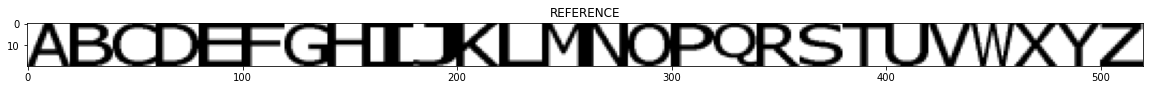

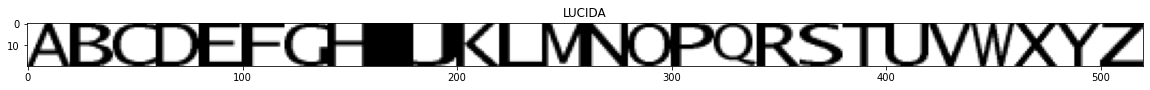

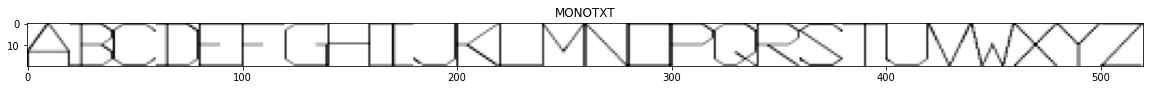

In [48]:
for font in eigenfont_groupby["font"].values[0][:5]: plot_font(font)

This is what the eigenfonts shown so far look like:

array([ 0.00000000e+00,  0.00000000e+00,  8.10568163e-05, ...,
       -1.62577658e-02, -1.86228766e-02, -1.51862525e-02])

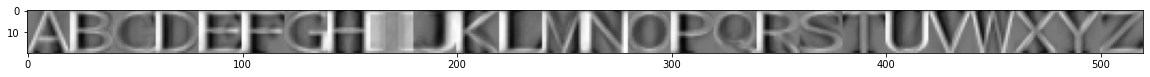

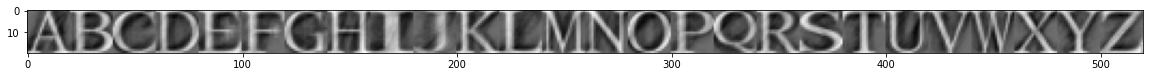

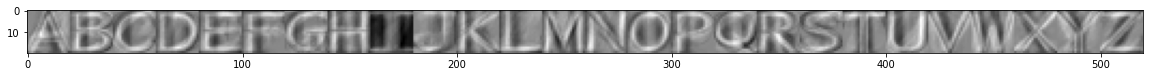

In [21]:
plot_eigenfont(eigvecs_normalized, 2)
plot_eigenfont(eigvecs_normalized, 3)
plot_eigenfont(eigvecs_normalized, 4)

While this method is good, it still seems unsatisfactory in properly grouping up the fonts by visual traits.

**There is also PCA, but for the other, transposed axis:**

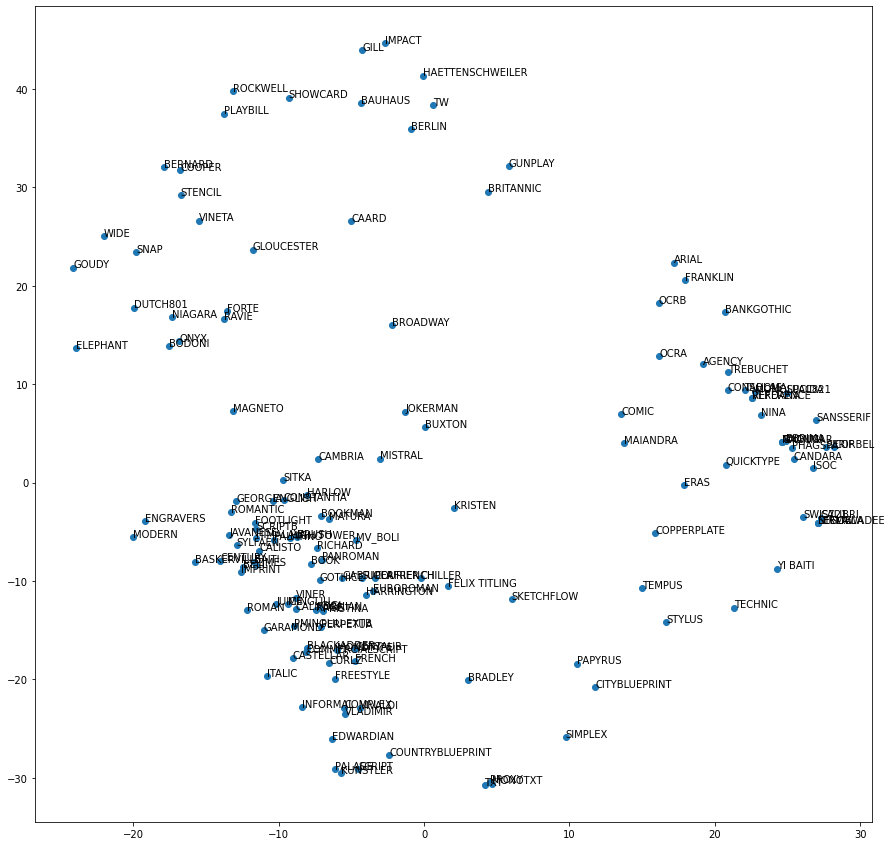

In [77]:
from sklearn.decomposition import PCA
pca2 = PCA(2).fit_transform(eig_fonts_x)
x = pca2[:,-1]
y = pca2[:,-2]
n = passed_font_families
            
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

There is some semblance of logic:

* In the bottom-most left, there is a cluster of fonts that is Edwardian, and Kunstler, Palace, and Script (but the latter 3's labels are clumped together and hard to read). These are all cursive fonts.


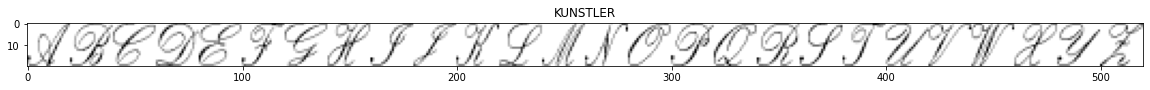

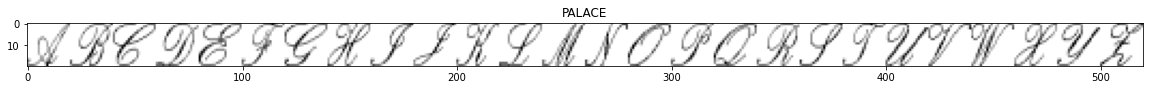

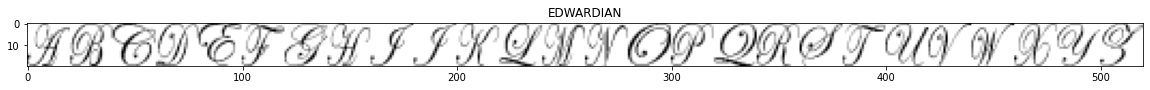

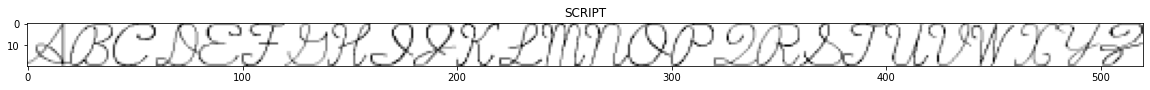

In [78]:
plot_font("KUNSTLER")
plot_font("PALACE")
plot_font("EDWARDIAN")
plot_font("SCRIPT")

### Method 2. Spectral Embedding built from a Similarity Matrix (Normalized Gramian Matrix)

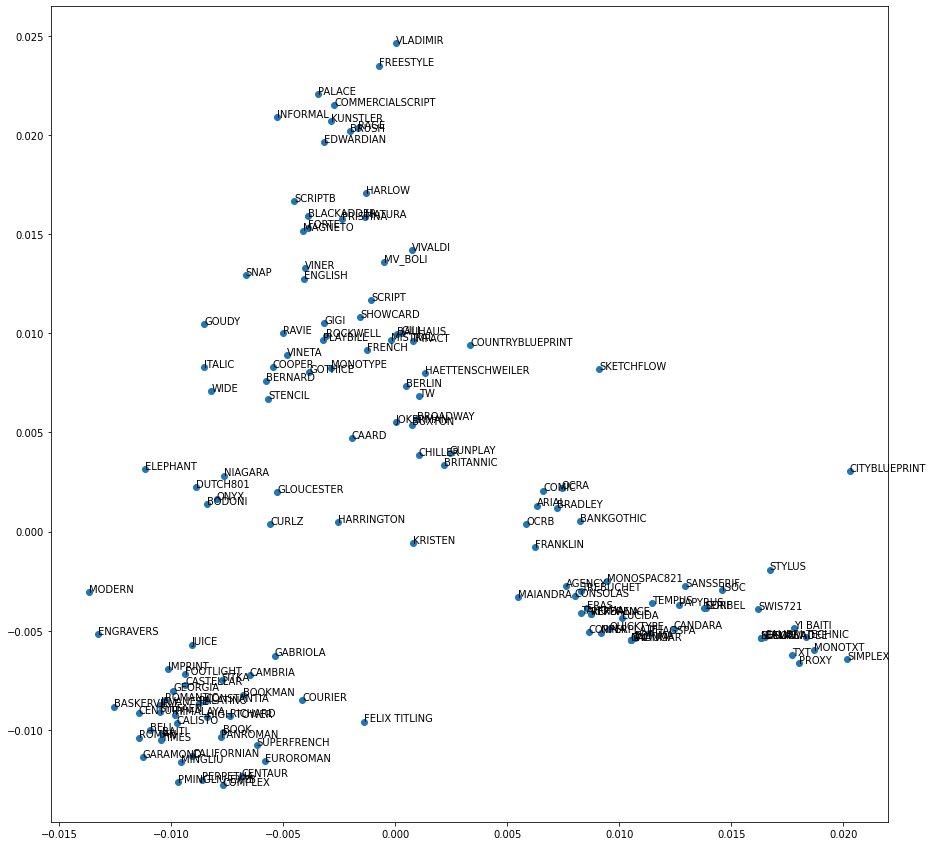

In [24]:
eig_fonts_x_normalized = normalize(unraveled_alphabets, axis=1) #
eig_fonts_similarity_matrix = eig_fonts_x_normalized @ eig_fonts_x_normalized.T
W = eig_fonts_similarity_matrix

N_EMBEDDINGS = 2
embedding = sklearn.manifold.spectral_embedding(W, n_components=N_EMBEDDINGS)

eigfont_embeddings_df = pd.DataFrame()
eigfont_embeddings_df["font"] = passed_font_families
embedding_column_names = []
for i in range(N_EMBEDDINGS):
    embedding_column_name = "embedding_{0}".format(i)
    embedding_column_names.append(embedding_column_name)
    eigfont_embeddings_df[embedding_column_name] = embedding[:,i]


# embedding.shape
x = embedding[:,0]
y = embedding[:,1]
n = passed_font_families
            
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

* After the use of spectral embedding, we can clearly see some well defined clusters. 
  * Serifed Fonts like Garamond and Cambria are clumped on the bottom left.
  * San-Serifed Fonts like Segoe and Bank Gothic are clumped on the right
  * Scripted or Decorative Fonts like Blackadder and Edwardian are clumped on the top
 

### Using K-means Clustering

* This method seems promising, as categories seem to be easily seperable.
* **K-Means Clustering** will be used, with k=3 since there are 3 visible groups.

In [25]:
N_CLUSTERS = 3
np.random.seed(1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(eigfont_embeddings_df[embedding_column_names])
kmeans.labels_

eigfont_embeddings_df["cluster"] = kmeans.labels_

# Another thing we can do is to be less discrete with grouping the fonts. 
# Instead being binary, this part will ambiguously decide how each font can be grouped under each cluster group as a proportion, based on the distance to the cluster centroid

cluster_center_i_distance_column_names = []
for i in range(N_CLUSTERS):
    cluster_center_i = kmeans.cluster_centers_[i]

    cluster_center_i_distance = 0
    for j in range(N_EMBEDDINGS):
        cluster_center_i_distance += (eigfont_embeddings_df["embedding_{0}".format(j)] - cluster_center_i[j])**2
    cluster_center_i_distance_column_name = "cluster_center_{0}_distance".format(i)
    cluster_center_i_distance_column_names.append(cluster_center_i_distance_column_name)
    eigfont_embeddings_df[cluster_center_i_distance_column_name] = cluster_center_i_distance

eigfont_embeddings_df_cluster_center_i_distance = eigfont_embeddings_df[cluster_center_i_distance_column_names]
#((eigfont_embeddings_df_cluster_center_i_distance)*-1).add(eigfont_embeddings_df_cluster_center_i_distance.max(axis=1),axis="index")

#(0.5*(1-(normalize(eigfont_embeddings_df_cluster_center_i_distance, axis=1,norm="l1"))))#.sum(axis=1)
eigfont_embeddings_df_cluster_center_i_distance = 1/eigfont_embeddings_df_cluster_center_i_distance
eigfont_embeddings_df_cluster_center_i_proximity = normalize(eigfont_embeddings_df_cluster_center_i_distance,axis=1,norm="l1")
eigfont_embeddings_df[cluster_center_i_distance_column_names] = eigfont_embeddings_df_cluster_center_i_proximity
eigfont_embeddings_df = eigfont_embeddings_df.rename(columns=dict([("cluster_center_{0}_distance", "cluster_center_{0}_proximity") for i in range(N_CLUSTERS)]))

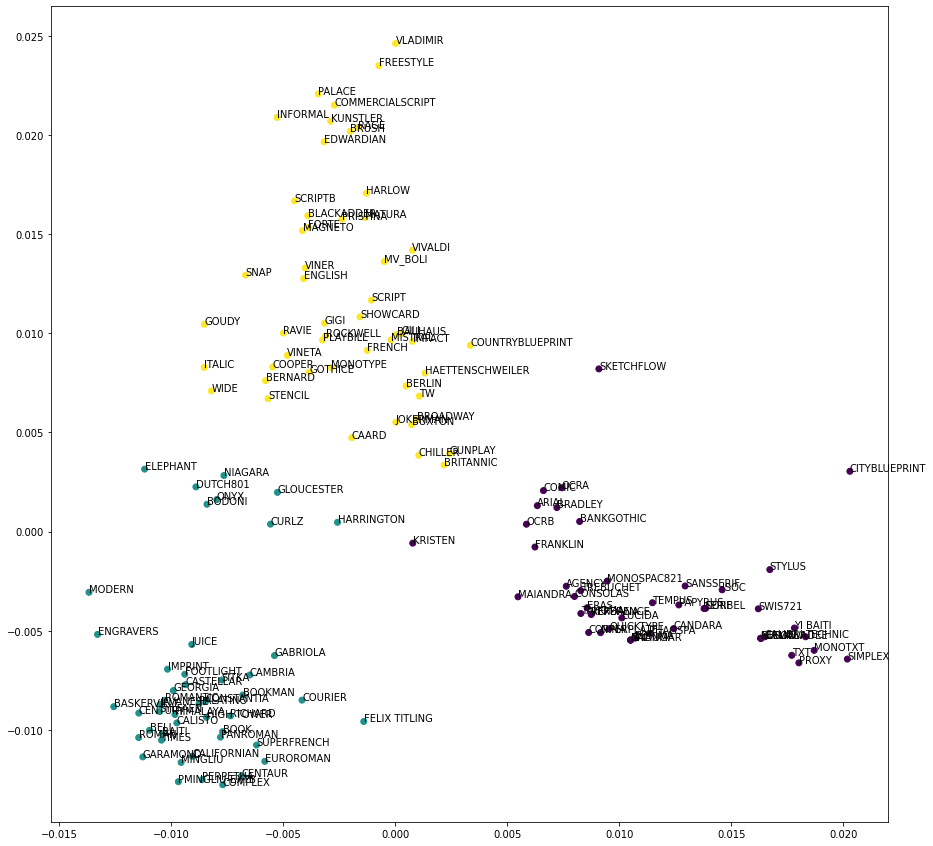

In [26]:
x = eigfont_embeddings_df["embedding_0"]
y = eigfont_embeddings_df["embedding_1"]
fonts = eigfont_embeddings_df["font"]
            
colors=eigfont_embeddings_df["cluster"]
#colors=((eigfont_embeddings_df_cluster_center_i_proximity)*255).astype(int)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y,c=colors)

for i, txt in enumerate(fonts):
    ax.annotate(txt, (x[i], y[i]))

In [27]:
group_first = eigfont_embeddings_df[eigfont_embeddings_df["cluster"]==0].sort_values(["cluster_center_0_distance"],
                                                                                    ascending=False)["font"].values
group_second = eigfont_embeddings_df[eigfont_embeddings_df["cluster"]==1].sort_values(["cluster_center_1_distance"],
                                                                                     ascending=False)["font"].values
group_third = eigfont_embeddings_df[eigfont_embeddings_df["cluster"]==2].sort_values(["cluster_center_2_distance"],
                                                                                    ascending=False)["font"].values

#### **Verification of Groups**

* After grouping up the fonts using K-means clustering, its necessary to visualize the fonts together in their groups to see if the unsupervised machine learning steps used so far actually did group the fonts apart by visual traits.

#### Visualizing Fonts in Group 1

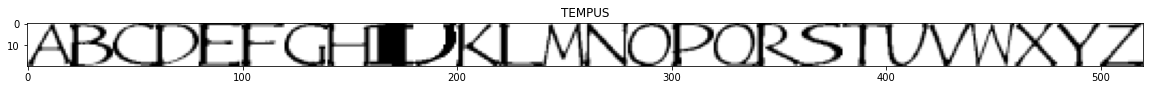

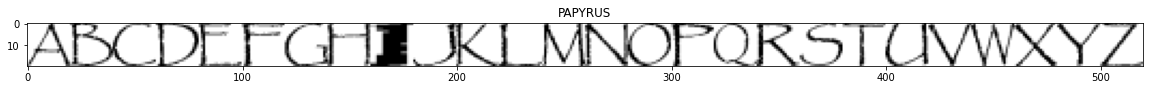

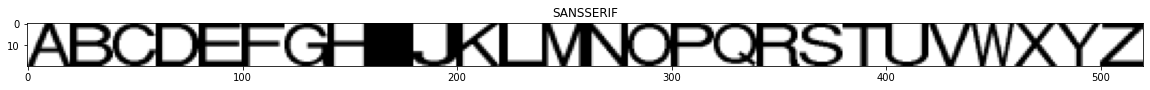

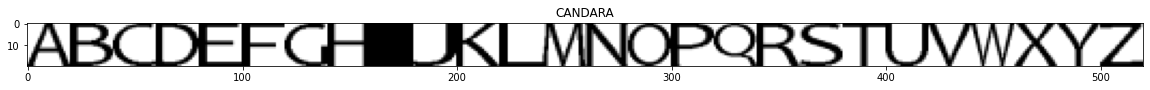

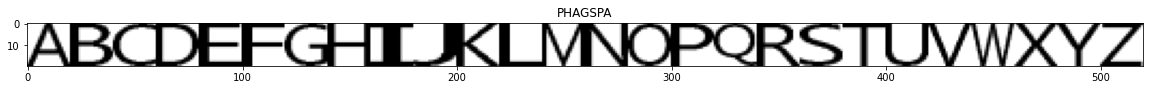

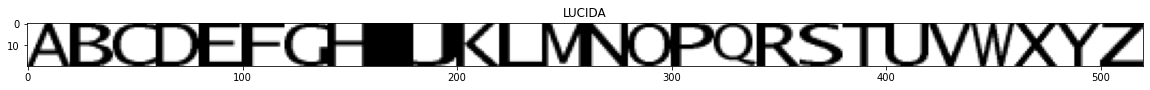

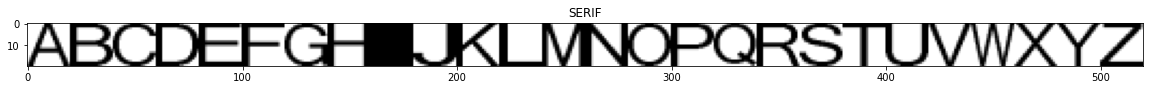

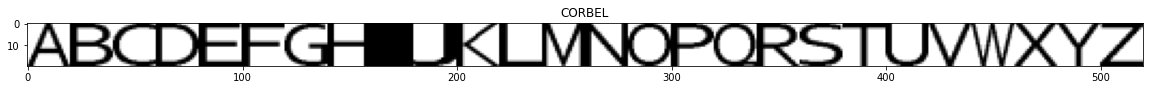

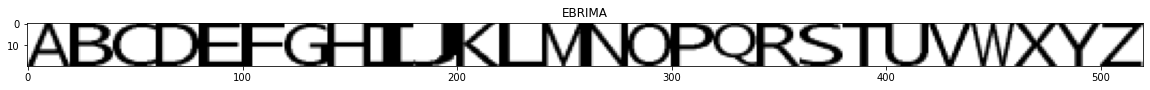

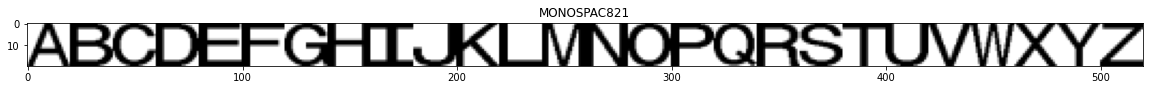

In [28]:
for i in group_first[:10]: plot_font(i)

#### Visualizing Fonts in Group 2

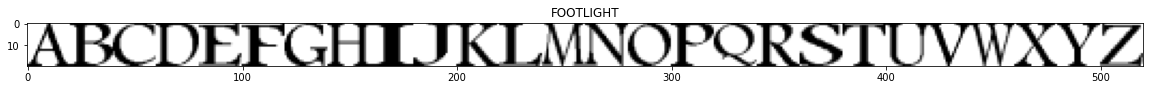

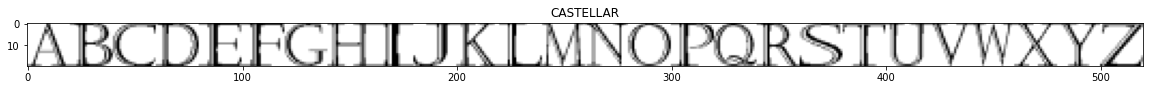

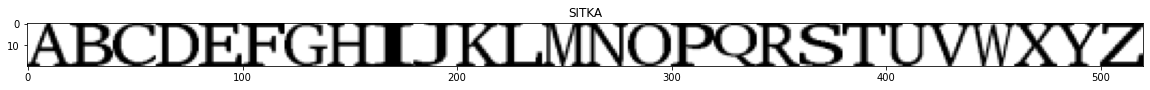

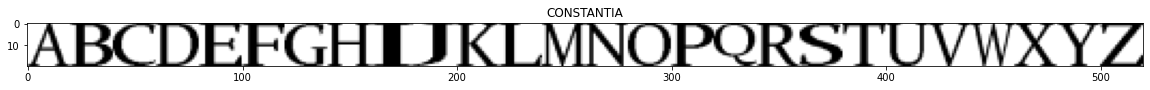

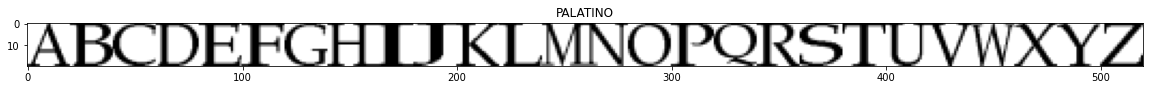

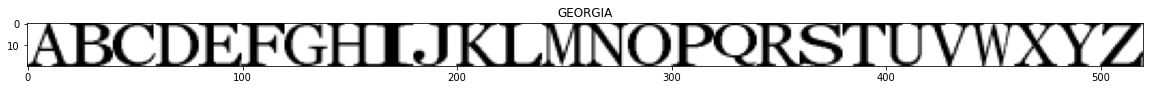

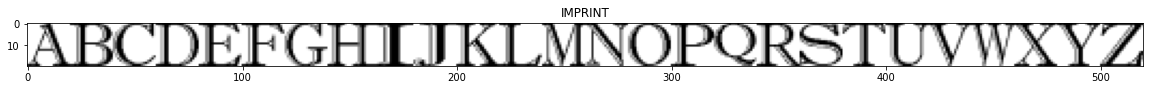

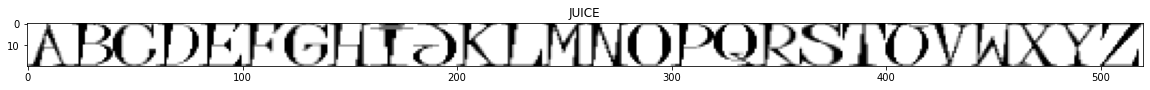

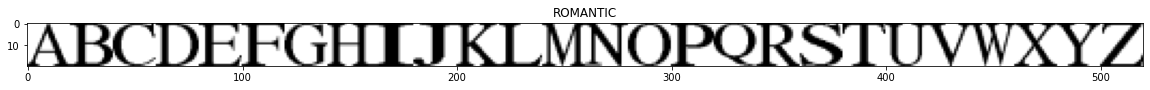

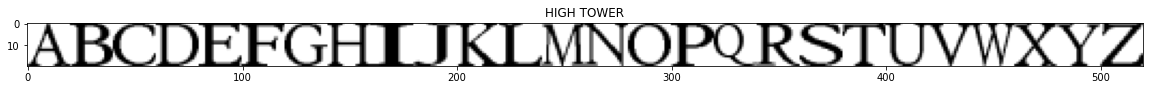

In [29]:
for i in group_second[:10]: plot_font(i)

#### Visualizing Fonts in Group 3

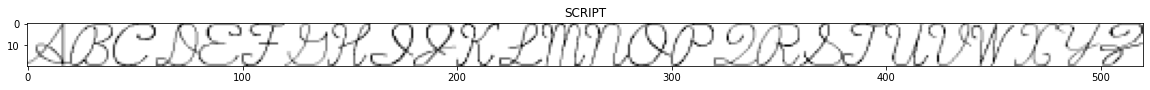

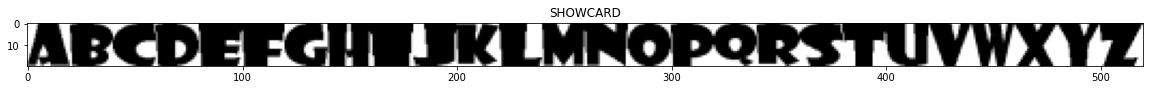

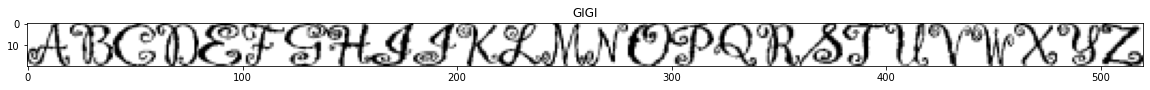

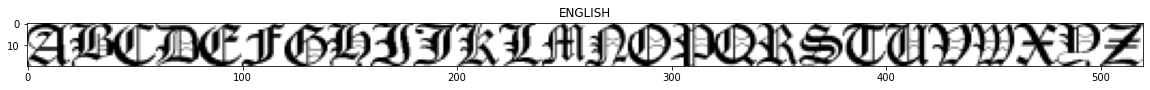

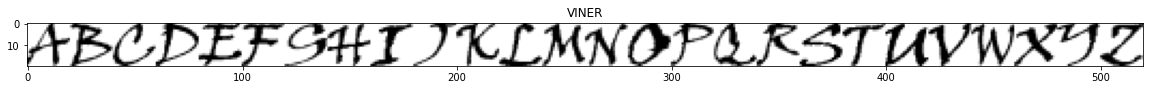

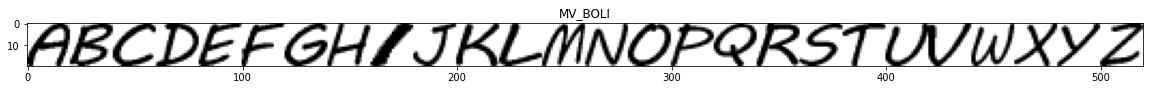

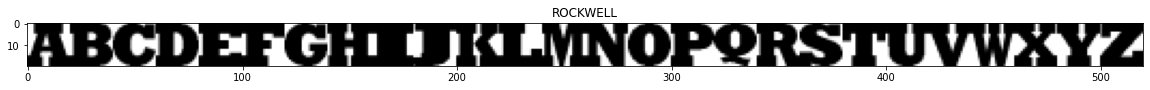

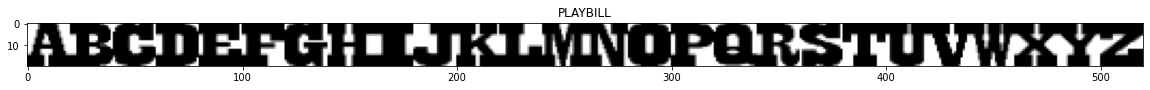

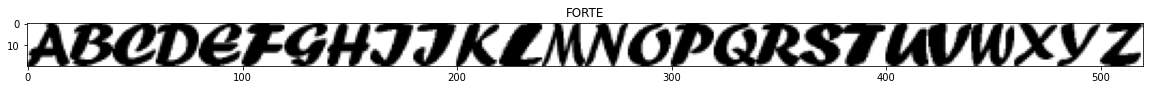

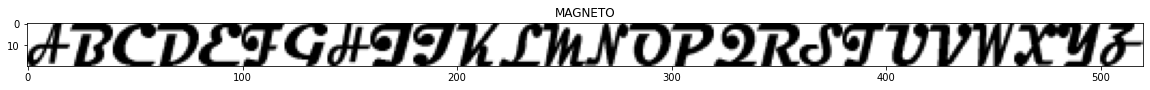

In [30]:
for i in group_third[:10]: plot_font(i)

### **Evaluation of Clustering**

* After using clustering for unsupervised machine learning methods to cluster the fonts, observations can be made:
    * The 1st group seems to perfectly be **sans-serif** fonts
    * The 2nd group seems to perfectly be **serif** fonts. But some non serifed fonts fell in, specifically Curlz and Harrington
    * The third group seems to be mostly **"everything else"**, including decorative, or hand-scribed fonts. Decoraive fonts include those very unique in their own right, like Jokerman, or Broadway. A big subgroup of this group are calligraphy fonts like Gothice, as well as cursive handwriting- like Edwardian and Kunstler.
        * However, there are a few fonts that could have been serif fonts (like Bernard, Vineta, Stencil, etc), or sans-serif fonts (like Gunplay). This needs more future focus.

* This method seems to be the best so far for categorizing labels for the Convolutional Neural Network

## **Part 3: Convolutional Neural Network using Part 2's Labellings**

We can finally create the training and testing dataset. This will be similar to the very first csv-reading iteration for loop, except that:
* We will include all characters; for this case, those are lowercase and number characters
* The y's are the cluster grouping labels
* The x's are individual 20x20 images of the characters

### **Building the Convolutional Neural Network**


In [31]:
def prepare_font_df_all(font_df_orig):
    # For each font's csv table, the column "m_label" denotes an identifier for a certain character
    # The variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
    MIN_M_LABEL = 33
    MAX_M_LABEL = 126
    m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
    m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
    m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
    m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

    CHOSEN_M_LABELS = []
    CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
    CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
    CHOSEN_M_LABELS += m_labels_alphanum_num

    curr_font_df = font_df_orig
    
    ERROR_FONTS = ['BITSTREAMVERA','CREDITCARD', 'E13B', 'HANDPRINT', 'MONEY', 'NUMERICS', 'VIN']
    curr_font_df = curr_font_df[curr_font_df["font"].isin(ERROR_FONTS)==False]
    # Remove Errored Fonts
    curr_font_df = curr_font_df[curr_font_df["fontVariant"]!="scanned"]
    # Removed Scanned Pictures
    curr_font_df = curr_font_df[curr_font_df["m_label"].isin(CHOSEN_M_LABELS)] 
    # get the chosen labels 
    curr_font_df = curr_font_df.sort_values(["font","m_label"]) 
    # make sure that the characters are in order, which is necessary for a horizontal concatenation and consistent embedding later on.
    curr_font_df = curr_font_df[curr_font_df["strength"] <= 0.5] 
    # remove bolded
    curr_font_df = curr_font_df[curr_font_df["italic"] <= 0.5] 
    # remove italicized
    curr_font_df = curr_font_df.drop_duplicates(subset=["font","m_label","strength","italic"]) 
    curr_font_df = curr_font_df.sort_values(["font","m_label"])
    return curr_font_df

In [32]:
x_train = []
x_test = []
y_train = []
y_test = []

font_folder_path = '/kaggle/input/uci-fonts-dataset/'
range_len_passed_font_families = range(len(passed_font_families))
range_len_passed_font_families = tqdm(range_len_passed_font_families)
for i in range_len_passed_font_families:
    passed_font_family = passed_font_families[i]
    #if (((i+1)%25)==0): print(i+1, len(passed_font_families));
    uci_font_family_csv_file_name = passed_font_family + ".csv"
    uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    curr_font_df = prepare_font_df_all(temp_uci_font_family_df_orig)
    curr_font_df = curr_font_df[pixel_column_names]
    
    train_test = np.random.choice([1,0],size=len(curr_font_df), p=[0.75, 0.25])
    train_character_pics_flattened= curr_font_df[train_test.astype(bool)]
    train_character_pics_reshaped = train_character_pics_flattened.values.reshape(train_character_pics_flattened.shape[0],20,20)

    train_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    train_ohes = np.tile(train_ohe[0],(train_character_pics_flattened.shape[0],1))

    test_character_pics_flattened= curr_font_df[~train_test.astype(bool)]
    test_character_pics_reshaped = test_character_pics_flattened.values.reshape(test_character_pics_flattened.shape[0],20,20)

    test_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    test_ohes = np.tile(test_ohe[0],(test_character_pics_flattened.shape[0],1))

    x_train += list(train_character_pics_reshaped)
    y_train += list(train_ohes)
    x_test += list(test_character_pics_reshaped)
    y_test += list(test_ohes)

    #unraveled_unsupervised.append(temp_uci_font_family_char_concat)

100%|██████████| 146/146 [00:36<00:00,  3.97it/s]


In [33]:
# For this cell, decide if you want to train with sparse or regular categorical cross entropy
# I went with sparse, which changed the y labels to be scalar (the argmax) rather than softmaxed vectors

IS_SPARSE = True
LOSS_FUNCTION = 'categorical_crossentropy';

if IS_SPARSE:
    LOSS_FUNCTION = 'sparse_categorical_crossentropy'; 
    y_train = np.argmax(np.array(y_train),axis=1)
    y_test = np.argmax(np.array(y_test),axis=1)

In [34]:
N_CLASSES = N_CLUSTERS

In [35]:
def middle_fcn_layer_function(filters, kernel_size, strides, dropout_rate,x):
    x = tf.keras.layers.Conv2D(filters=filters, 
                               kernel_size=kernel_size, 
                               strides=strides,
                               padding="same")(x) 
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

len_classes=N_CLASSES
dropout_rate=0.2

input_layer = tf.keras.layers.Input(shape=(None, None, 1)) # maybe change shape to just None, None if grayscale
## Middle FCN Layer

x = middle_fcn_layer_function(filters=5, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=input_layer)
x = middle_fcn_layer_function(filters=10, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=x)
## take account of kernel size= 3 isfilter size not != RGB
## should it be bigger?

x = middle_fcn_layer_function(filters=20, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=256, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=512, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)

x = middle_fcn_layer_function(filters=10, kernel_size=1, strides=1, dropout_rate=dropout_rate, x=x)
## penult layer

## Last FCN Layer
x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs=input_layer, outputs=predictions)
## This is functional API
## https://keras.io/guides/functional_api/
model.compile(optimizer=tf.optimizers.Adam(),loss=LOSS_FUNCTION,metrics=['accuracy'])

2022-10-16 16:48:30.794413: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 5)     50        
_________________________________________________________________
dropout (Dropout)            (None, None, None, 5)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 5)     20        
_________________________________________________________________
activation (Activation)      (None, None, None, 5)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 10)    460       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 10)    0     

In [37]:
model.fit(np.array(x_train), (y_train), epochs = 20)

Epoch 1/20


2022-10-16 16:48:31.284421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


214/214 [==============================] - 6s 21ms/step - loss: 1.2216 - accuracy: 0.3832
Epoch 2/20
214/214 [==============================] - 4s 21ms/step - loss: 1.0533 - accuracy: 0.4694
Epoch 3/20
214/214 [==============================] - 4s 21ms/step - loss: 1.0010 - accuracy: 0.5214
Epoch 4/20
214/214 [==============================] - 4s 21ms/step - loss: 0.9638 - accuracy: 0.5619
Epoch 5/20
214/214 [==============================] - 4s 21ms/step - loss: 0.9447 - accuracy: 0.5723
Epoch 6/20
214/214 [==============================] - 4s 21ms/step - loss: 0.9055 - accuracy: 0.5951
Epoch 7/20
214/214 [==============================] - 5s 21ms/step - loss: 0.8836 - accuracy: 0.6121
Epoch 8/20
214/214 [==============================] - 4s 21ms/step - loss: 0.8588 - accuracy: 0.6156
Epoch 9/20
214/214 [==============================] - 4s 21ms/step - loss: 0.8297 - accuracy: 0.6402
Epoch 10/20
214/214 [==============================] - 5s 21ms/step - loss: 0.8201 - accuracy: 0.6475


In [38]:
((np.argmax(model.predict(np.array(x_test)),axis=1))==y_test).mean()

0.6905405405405406

In [39]:
PATH_FOLDER = ""
MODEL_FILE_PATH = PATH_FOLDER + "/versatile_font_embedding_cluster_classifier_cnn1.h5"
model.save(MODEL_FILE_PATH)

# START FROM HERE

# ORIG MODEL IS PATH_FOLDER + "/versatile_font_embedding_cluster_classifier_cnn.h5"
# KNEIGHBOR MODEL IS PATH_FOLDER + "/versatile_font_kn_embedding_cluster_classifier_cnn.h5"

model1 = keras.models.load_model(MODEL_FILE_PATH)

## **Part 4: OpenCV for Character Segmentation, and Font Type Classification of Photo-Scanned Text**

* We can now finally input a picture of text through the CNN and find which "font type" (serif, san-serif, decorated) it is mostly classified with.
* I originally intended for this project to be used on historic, archived, photo-scanned documents. This means things like Newspapers, postcards, war letters, etc. 
* Obviously, please use sources from the Roman alphabet
* I will be using an old handwritten cursive letter as my example

In [40]:
#url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2016%2F03%2F10%2F343179-landscape-nature.jpg"
url = "https://mha.mun.ca/mha/cw/images/margins/scanned_letters/second-letter001.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/f/f5/Spencerian_example.jpg"
#url = "https://www2.wheaton.edu/bgc/archives/images/CNs/285/285-027-014/005.jpg"
#url = "https://media.defense.gov/2016/Jan/21/2001336426/-1/-1/0/160121-F-HF287-001.JPG"
#url = "https://upload.wikimedia.org/wikipedia/commons/f/f5/Spencerian_example.jpg"

url_response = urllib.request.urlopen(url)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8),-1)
img = img[:,:,::-1]

379


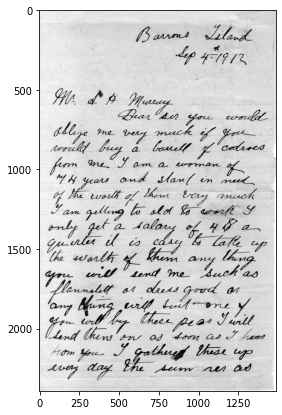

In [41]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = gray
plt.imshow(img, cmap='gray')
img = 255-img

cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
#ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

#th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
find_contours_output = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#print((find_contours_output[0]))

contours = find_contours_output[0]
hier =  find_contours_output[1]
print(len(contours))

* The cv2 package will perform image segmentation to cut out each character it can find on the image. But it's not very perfect, as it might clump many letters together, or pick up things that aren't text

Predicted Classes are  [0.04582826 0.04296988 0.91120183]


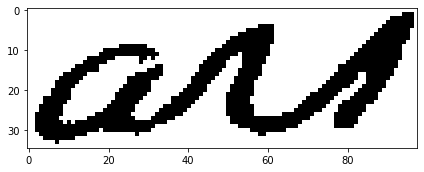

In [42]:
# one exampleof an extracted image
contour_i = 231
x, y, w, h = cv2.boundingRect(contours[contour_i])
cnt = contours[contour_i]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

max_x = np.max(box[:,0])
min_x = np.min(box[:,0])
max_y = np.max(box[:,1])
min_y = np.min(box[:,1])

extraction = img[min_y:max_y,min_x:max_x]
plt.imshow(255-img[min_y:max_y,min_x:max_x], cmap="gray")
prediction_vector = model1.predict(np.array([extraction]))[0]
print("Predicted Classes are ",prediction_vector)

* The Neural Network model puts this symbol as highest in the 3rd class (at 0.91). The 3rd class included cursives fonts.

In [43]:
predictions = []
range_len_contours = range(len(contours))
range_len_contours = tqdm(range_len_contours)
for contour_i in range_len_contours:
    #if (((contour_i+1)%100)==0): print(contour_i+1, (len(contours)));
    try:
        x, y, w, h = cv2.boundingRect(contours[contour_i])
        cnt = contours[contour_i]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        max_x = np.max(box[:,0])
        min_x = np.min(box[:,0])
        max_y = np.max(box[:,1])
        min_y = np.min(box[:,1])

        extraction = img[min_y:max_y,min_x:max_x]
        prediction = model1.predict(np.array([extraction]))[0]
        predictions.append(prediction)
    except:
        pass
segmented_character_font_embedding_cluster_classification_predictions = predictions

100%|██████████| 379/379 [00:22<00:00, 16.72it/s]


In [44]:
segmented_character_font_embedding_cluster_classification_predictions_avg = np.nan_to_num(np.array(segmented_character_font_embedding_cluster_classification_predictions)).mean(axis=0)# = predictions

In [45]:
print(segmented_character_font_embedding_cluster_classification_predictions_avg)
print("Highest Font Category of Photoscanned Document:", 
      np.argmax(segmented_character_font_embedding_cluster_classification_predictions_avg)+1)

[0.15999225 0.12295213 0.7170555 ]
Highest Font Category of Photoscanned Document: 3


* After aggregating up to the predictions for all the extracted subsets found by cv2, the 3rd category seems to be the highest likely category (at 0.71). This makes sense, as the cursive category seems to be the predominant font category of the input photoscanned letter.